In [1]:
                                                                                                                                                                                                                              import pandas as pd
import numpy as np
import os
import shutil
import glob
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from itertools import combinations
from joblib import Parallel, delayed, dump
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from pathlib import Path
from joblib import load
from sklearn.model_selection import GridSearchCV
from scipy.special import softmax  

In [ ]:
dataset = pd.read_pickle('pairwise_emotional_LR/dataset_v99_v110.pkl') 

In [3]:
unique_sample_ids = dataset['sample_id'].unique()
train_ids, test_ids = train_test_split(
    unique_sample_ids,
    test_size=0.25,
    random_state=42,
    stratify=None)

In [ ]:
corr_graph_path = "graph_LR.csv"
corr_df = pd.read_csv(corr_graph_path)  
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))

In [4]:
train_ids_set = set(train_ids)
test_ids_set  = set(test_ids)
number_of_vertices =380
features           = ['mean','std']

In [5]:
number_of_vertices = 380
vertex_columns = np.arange(1, number_of_vertices)
vertex_pairs = list(combinations(vertex_columns, 2))
total_pairs = len(vertex_pairs)

# EMOTIONAL (LR) - Logistic regression (without corr)

In [11]:
base_dir = 'vertices_mean_extended/EMOTIONAL/LR'  
output_dir = 'pairwise_emotions'

In [5]:
#features = ['mean', 'std', 'autocorr_lag1', 'n_peaks', 'mean_peak_amp', 'mean_interpeak_interval']
features = ['mean', 'std']

In [33]:
def create_pairwise_dataset(base_dir, features):
    pattern = os.path.join(base_dir, '**', '*.pickle')
    pickle_files = glob.glob(pattern, recursive=True)
    all_files = []
    for file_path in pickle_files:
        data = pd.read_pickle(file_path)
        class_label = file_path.split('_')[4].replace('.pickle', '')
        data['class'] = class_label
        data['sample_id'] = (file_path.split('/')[3]).split('_')[0]
        all_files.append(data)


    full_data = pd.concat(all_files)
    full_data.reset_index(inplace=True)
    full_data.rename(columns={'index': 'vertex'}, inplace=True)
    full_data['vertex'] += 1
    data = full_data.pivot_table(index=['sample_id', 'class'],
                              columns='vertex',
                              values=['mean', 'std'])
    data.reset_index(inplace=True)
    data.columns = [f"{feat}_{vertex}" if vertex else feat for feat, vertex in data.columns]
    return data

In [ ]:
data = create_pairwise_dataset(base_dir, features)

In [37]:
def save_pairwise_dataset(pair, output_dir, feature_types, data):
    v1, v2 = pair
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f'dataset_v{v1}_v{v2}.pkl')
    if os.path.exists(filename):
        print(f"File already exists: {filename} - Skipping processing")
        return False

    cols_to_extract = []
    for feat in feature_types:
        cols_to_extract.extend([f'{feat}_{v1}', f'{feat}_{v2}'])
    cols_to_extract.extend(['class', 'sample_id'])
    
    try:
        subset = data[cols_to_extract].copy()
        
        rename_dict = {}
        for feat in feature_types:
            rename_dict.update({
                f'{feat}_{v1}': f'{feat}_v1',
                f'{feat}_{v2}': f'{feat}_v2'
            })
        
        subset.rename(columns=rename_dict, inplace=True)
        subset.to_pickle(filename)
        return True
        
    except Exception as e:
        print(f"Error processing pair ({v1}, {v2}): {str(e)}")
        return False
    
def process_pairs_in_parallel(pairs, output_dir, feature_types, data, num_processes=None):
    if num_processes is None:
        num_processes = max(1, cpu_count() - 1)

    args = [
        (pair, output_dir, feature_types, data)
        for pair in pairs
    ]

    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(pool.starmap(save_pairwise_dataset, args), total=len(args))
        )

    success_count = sum(results)


In [ ]:

process_pairs_in_parallel(vertex_pairs, output_dir, features, data)

In [54]:
le_global = LabelEncoder()
le_global.fit(['neut', 'fear']) 

LabelEncoder()

In [54]:
def train_logistic_regression(dataset_path, model_output_dir, report_output_dir, feature_bases, le = le_global):
    filename = os.path.basename(dataset_path)
    v1, v2 = filename.replace('dataset_v', '').replace('.pkl', '').split('_v')
    df = pd.read_pickle(dataset_path)

    df['class_encoded'] = le.transform(df['class'])

    train_data = df[df['sample_id'].isin(train_ids)].reset_index(drop=True)
    test_data = df[df['sample_id'].isin(test_ids)].reset_index(drop=True)

    feature_columns = [f"{base}_{v}" for base in feature_bases for v in ('v1', 'v2')]

    X_train = train_data[feature_columns].values
    y_train = train_data['class_encoded'].values
    X_test = test_data[feature_columns].values
    y_test = test_data['class_encoded'].values


    model = LogisticRegression(multi_class='ovr', solver='lbfgs',
                               max_iter=10000, n_jobs=1)
    model.fit(X_train, y_train)

    #if evaluation is needed
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Test accuracy: {accuracy:.4f}")

    # report = classification_report(y_test, y_pred,
                                   # target_names=le.classes_,
                                   # output_dict=True,
                                   # zero_division=0)

    # report_filename = f'report_v{v1}_v{v2}.json'
    # report_path = os.path.join(report_output_dir, report_filename)
    # with open(report_path, 'w') as f:
    #     json.dump(report, f, indent=4)

    model_filename = f'logreg_v{v1}_v{v2}.joblib'
    model_path = os.path.join(model_output_dir, model_filename)
    dump({'model': model, 'label_encoder': le}, model_path)


In [12]:
dataset_dir = output_dir 
dataset_files = [
    os.path.join(dataset_dir, fname) 
    for fname in os.listdir(dataset_dir) 
    if fname.endswith('.pkl')
]
print(f"Найдено {len(dataset_files)} парных датасетов.")

Найдено 71631 парных датасетов.


In [135]:
model_output_dir = 'models_emotional'
report_output_dir = 'training_reports_emotional'
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(report_output_dir, exist_ok=True)
results = Parallel(n_jobs=1)(
    delayed(train_logistic_regression)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        report_output_dir=report_output_dir,
        feature_bases = features
    ) for path in tqdm(dataset_files)
)

  0%|                                       | 103/71631 [00:01<15:50, 75.25it/s]

100%|█████████████████████████████████████| 71631/71631 [17:12<00:00, 69.40it/s]


In [9]:
pkl_paths = []
base_dir = 'vertices_mean_extended/'  
subfolders = ['EMOTIONAL/LR']

for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)  
    for test_id in test_ids:
        for filename in os.listdir(folder_path):
            if test_id in filename and filename.endswith('.pickle'):
                pkl_paths.append(os.path.join(folder_path, filename))

In [138]:
models_dir = 'models_emotional'
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [139]:
def process_pair(v1, v2, data_np, models):
    model = models.get((v1 + 1, v2 + 1))
    if model is None:
        raise ValueError(f"Модель для вершин ({v1 + 1}, {v2 + 1}) не найдена.")
    pair_data = np.hstack((data_np[v1], data_np[v2])).reshape(1, -1)
    probabilities = model.predict_proba(pair_data)[0]
    return probabilities

# Prediction with argmax of average

In [140]:
correct_predictions = 0
total_files = len(pkl_paths)
prediction_results = []
pairs = list(combinations(range(number_of_vertices - 1), 2))
                            
for file_path in tqdm(pkl_paths):
    data = pd.read_pickle(file_path)
    data_np = data[features].values  
    true_class = file_path.split('_')[4].split('.')[0]
    
    results = Parallel(n_jobs=1)(
        delayed(process_pair)(i, j, data_np, models)
        for i, j in pairs
    )
    total_probabilities = np.sum(results, axis=0)
 
    average_probabilities = total_probabilities / len(results)
    predicted_class_index = np.argmax(average_probabilities)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    
    if predicted_class == true_class:
        correct_predictions += 1
    prediction_results.append({
        'file_path': file_path,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'confidence': average_probabilities[predicted_class_index]
    })
    
accuracy = correct_predictions / total_files
print(f'Total accuracy: {accuracy:.4f}')

100%|███████████████████████████████████████| 292/292 [1:06:53<00:00, 13.74s/it]

Total accuracy: 0.5719


In [141]:
results_df = pd.DataFrame(prediction_results)
results_df.to_csv('prediction_results_emotional_v1.csv', index=False)

In [142]:
df = pd.read_csv('prediction_results_emotional_v1.csv')
df['correct'] = df['true_class'] == df['predicted_class']
accuracy_per_class = df.groupby('true_class')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true_class
neut    97.260274
fear    17.123288
Name: Accuracy (%), dtype: float64


In [143]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(df['true_class'], df['predicted_class'])

print(classification_report(df['true_class'], df['predicted_class']))

              precision    recall  f1-score   support

        fear       0.86      0.17      0.29       146
        neut       0.54      0.97      0.69       146

    accuracy                           0.57       292
   macro avg       0.70      0.57      0.49       292
weighted avg       0.70      0.57      0.49       292



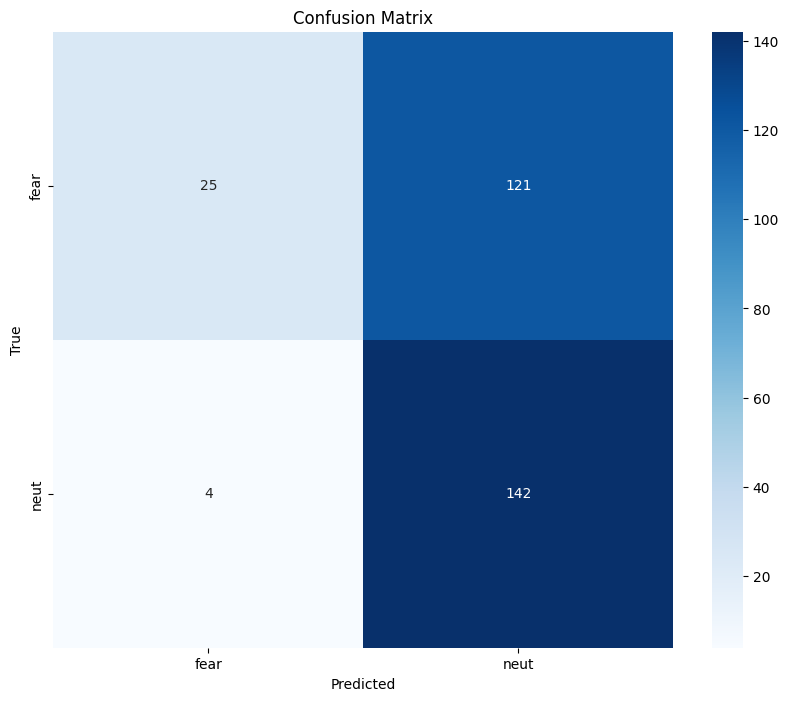

In [144]:

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['true_class'].unique(), 
            yticklabels=df['true_class'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Log-sum exp

In [147]:
from scipy.special import logsumexp

correct_predictions = 0
total_files = len(pkl_paths)
prediction_results = []
pairs = list(combinations(range(number_of_vertices - 1), 2))
                            
for file_path in tqdm(pkl_paths):
    data = pd.read_pickle(file_path)
    data_np = data[features].values  
    true_class = file_path.split('_')[4].split('.')[0]
    
    results = Parallel(n_jobs=1)(
        delayed(process_pair)(i, j, data_np, models)
        for i, j in pairs
    )
    results = np.array(results) 
    log_probs = np.log(results + 1e-12)  
    aggregated_log_probs = logsumexp(log_probs, axis=0) 

    predicted_class_index = np.argmax(aggregated_log_probs)
    predicted_class = le.inverse_transform([predicted_class_index])[0]
    
    if predicted_class == true_class:
        correct_predictions += 1
    prediction_results.append({
        'file_path': file_path,
        'true_class': true_class,
        'predicted_class': predicted_class,
        'confidence': average_probabilities[predicted_class_index]
    })
    
accuracy = correct_predictions / total_files
print(f'Total accuracy: {accuracy:.4f}')

100%|█████████████████████████████████████████| 292/292 [56:39<00:00, 11.64s/it]

Total accuracy: 0.5719


In [148]:
results_df = pd.DataFrame(prediction_results)
results_df.to_csv('prediction_results_emotional_logsumexp.csv', index=False)

# EMOTIONAL (LR) - Logistic regression (with corr)

In [15]:

def train_logistic_regression(dataset_path,
                              model_output_dir,
                              feature_bases,
                              corr_map,
                              le):

    fname = os.path.basename(dataset_path)
    v1, v2 = fname.replace('dataset_v', '').replace('.pkl', '').split('_v')
    
    model_fname = f'logreg_v{v1}_v{v2}.joblib'
    model_path  = os.path.join(model_output_dir, model_fname)
    if os.path.exists(model_path):
        return True

    df = pd.read_pickle(dataset_path)
    df['class_encoded'] = le.transform(df['class'])
    
    pair1 = f"{v1}_{v2}"
    pair2 = f"{v2}_{v1}"
    corr_value = corr_map.get(pair1, corr_map.get(pair2, 0.0))
    df['corr'] = corr_value
    
    feature_cols = [f"{base}_v1" for base in feature_bases] + \
                   [f"{base}_v2" for base in feature_bases] + \
                   ['corr']
    
    mask_train = df['sample_id'].isin(train_ids_set)
    mask_test  = df['sample_id'].isin(test_ids_set)
    
    X_train = df.loc[mask_train, feature_cols].values
    y_train = df.loc[mask_train, 'class_encoded'].values
    X_test  = df.loc[mask_test,  feature_cols].values
    y_test  = df.loc[mask_test,  'class_encoded'].values
    
    model = LogisticRegression(
        multi_class='ovr',
        solver='lbfgs',
        max_iter=10000,
        n_jobs=-1           
    )
    model.fit(X_train, y_train)

    dump({'model': model, 'label_encoder': le}, model_path)

In [ ]:
model_output_dir = 'models_emotional_corr'
report_output_dir = 'training_reports_emotional_corr'
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(report_output_dir, exist_ok=True)
results = Parallel(n_jobs=1)(
    delayed(train_logistic_regression)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        feature_bases = features,
        corr_map = corr_map
    ) for path in tqdm(dataset_files)
)

In [8]:
models_dir = 'models_emotional_corr'
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [9]:
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [ ]:
test_base_dir      = "vertices_mean_extended/EMOTIONAL/LR"

In [22]:
pkl_paths = []
base_dir = 'vertices_mean_extended/'  
subfolders = ['EMOTIONAL/LR']

for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)  
    for test_id in test_ids:
        for filename in os.listdir(folder_path):
            if test_id in filename and filename.endswith('.pickle'):
                pkl_paths.append(os.path.join(folder_path, filename))

In [13]:
def process_pair(i, j, data_np):
    key = (i, j) if (i, j) in models else (j, i)
    model = models[key]
    xi = data_np[i-1] 
    xj = data_np[j-1]
    pair_key = f"{i}_{j}" if f"{i}_{j}" in corr_map else f"{j}_{i}"
    corr = corr_map.get(pair_key, 0.0)
    x = np.hstack((xi, xj, corr)).reshape(1, -1)
    return model.predict_proba(x)[0]

In [10]:
le = LabelEncoder()
le.fit(['neut', 'fear']) 

LabelEncoder()

In [16]:
all_data = {p: pd.read_pickle(p) for p in tqdm(pkl_paths, desc="Loading all pkls")}


Loading all pkls: 100%|███████████████████| 1162/1162 [00:00<00:00, 2014.48it/s]


In [17]:
data_matrix = {p: df[features].values for p, df in all_data.items()}

In [18]:
def predict_for_sample(pkl):
    data_np = data_matrix[pkl]
    true_cls = true_labels[pkl]

    probas = Parallel(n_jobs=-1)(
        delayed(process_pair)(i, j, data_np)
        for i, j in pairs
    )
    total = np.sum(probas, axis=0)
    avg = total / len(pairs)
    pred_idx = np.argmax(avg)
    pred_cls = le.inverse_transform([pred_idx])[0]
    conf = avg[pred_idx]

    return {
        'file': pkl,
        'true': true_cls,
        'pred': pred_cls,
        'conf': float(conf),
        'correct': pred_cls == true_cls
    }


In [ ]:
results = Parallel(n_jobs=-1)(
    delayed(predict_for_sample)(p) for p in tqdm(pkl_paths)
)

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")


In [24]:
res_df = pd.DataFrame(results)
res_df.to_csv("prediction_results_emotions_lr_with_corr.csv", index=False)
res_df.head()

,file,true,pred,conf,correct
0,vertices_mean_extended/EMOTIONAL/LR/990366_LR_...,fear,neut,0.529063,False
1,vertices_mean_extended/EMOTIONAL/LR/990366_LR_...,neut,fear,0.594633,False
2,vertices_mean_extended/EMOTIONAL/LR/211316_LR_...,fear,fear,0.511817,True
3,vertices_mean_extended/EMOTIONAL/LR/211316_LR_...,neut,neut,0.533122,True
4,vertices_mean_extended/EMOTIONAL/LR/141119_LR_...,fear,neut,0.504564,False


In [28]:
df = pd.read_csv('prediction_results_emotions_lr_with_corr.csv')
df['correct'] = df['true'] == df['pred']
accuracy_per_class = df.groupby('true')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true
fear    76.712329
neut    76.027397
Name: Accuracy (%), dtype: float64


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(df['true'], df['pred'])

print(classification_report(df['true'], df['pred']))

              precision    recall  f1-score   support

        fear       0.76      0.77      0.76       146
        neut       0.77      0.76      0.76       146

    accuracy                           0.76       292
   macro avg       0.76      0.76      0.76       292
weighted avg       0.76      0.76      0.76       292



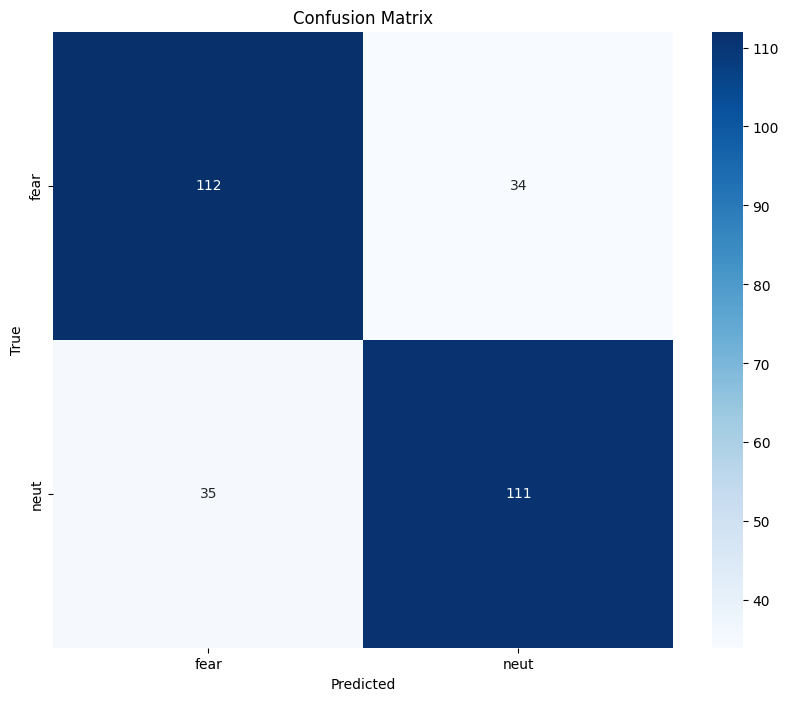

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['true'].unique(), 
            yticklabels=df['true'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Working memory (LR)

In [4]:
base_dir = 'vertices_mean_extended/WM/LR'  
output_dir = 'pairwise_working_memory_LR'

In [ ]:
data = create_pairwise_dataset(base_dir, features)
process_pairs_in_parallel(vertex_pairs, output_dir, features, data)

In [7]:
dataset_dir = output_dir 
dataset_files = [
    os.path.join(dataset_dir, fname) 
    for fname in os.listdir(dataset_dir) 
    if fname.endswith('.pkl')
]
print(f"Найдено {len(dataset_files)} парных датасетов.")

Найдено 71631 парных датасетов.


In [23]:
le = LabelEncoder()
le.fit(['0bk', '2bk']) 

LabelEncoder()

In [ ]:
model_output_dir = 'models_wm_corr'
report_output_dir = 'training_reports_wm_corr'
os.makedirs(model_output_dir, exist_ok=True)
os.makedirs(report_output_dir, exist_ok=True)
results = Parallel(n_jobs=-1)(
    delayed(train_logistic_regression)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        feature_bmodels_wm_corrases = features,
        corr_map = corr_map,
        le=le_global
    ) for path in tqdm(dataset_files)
)

In [10]:
models_dir = 'models_wm_corr'
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [11]:
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [13]:
pkl_paths = []
base_dir = 'vertices_mean_extended/'  
subfolders = ['WM/LR']

for subfolder in subfolders:
    folder_path = os.path.join(base_dir, subfolder)  
    for test_id in test_ids:
        for filename in os.listdir(folder_path):
            if test_id in filename and filename.endswith('.pickle'):
                pkl_paths.append(os.path.join(folder_path, filename))

In [14]:
true_labels = {}
for p in pkl_paths:
    sid, _, cls = Path(p).stem.split('_')
    true_labels[p] = cls

In [ ]:
all_data = {p: pd.read_pickle(p) for p in tqdm(pkl_paths, desc="Loading all pkls")}


In [16]:
data_matrix = {p: df[features].values for p, df in all_data.items()}

In [24]:
results = Parallel(n_jobs=-1)(
    delayed(predict_for_sample)(p) for p in tqdm(pkl_paths)
)

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")


100%|█████████████████████████████████████████| 292/292 [47:45<00:00,  9.81s/it]


Total accuracy: 0.9418


In [25]:
res_df = pd.DataFrame(results)
res_df.to_csv("prediction_results_wm_lr_with_corr.csv", index=False)
res_df.head()

,file,true,pred,conf,correct
0,vertices_mean_extended/WM/LR/990366_LR_2bk.pickle,2bk,2bk,0.575814,True
1,vertices_mean_extended/WM/LR/990366_LR_0bk.pickle,0bk,0bk,0.561274,True
2,vertices_mean_extended/WM/LR/211316_LR_0bk.pickle,0bk,0bk,0.523629,True
3,vertices_mean_extended/WM/LR/211316_LR_2bk.pickle,2bk,2bk,0.541745,True
4,vertices_mean_extended/WM/LR/141119_LR_2bk.pickle,2bk,2bk,0.530646,True


# Gambling (LR)

In [11]:
base_dir = 'vertices_mean_extended/GAMBLING/LR'  
output_dir = 'pairwise_gambling_LR'

In [12]:
dataset_dir = output_dir 
dataset_files = [
    os.path.join(dataset_dir, fname) 
    for fname in os.listdir(dataset_dir) 
    if fname.endswith('.pkl')
]
print(f"Найдено {len(dataset_files)} парных датасетов.")

Найдено 71631 парных датасетов.


In [13]:
le_global = LabelEncoder()
le_global.fit(['win', 'loss']) 

LabelEncoder()

In [ ]:
model_output_dir = 'models_gambling_corr'
os.makedirs(model_output_dir, exist_ok=True)
results = Parallel(n_jobs=-1)(
    delayed(train_logistic_regression)(
        dataset_path=path, 
        model_output_dir=model_output_dir, 
        feature_bases = features,
        corr_map = corr_map,
        le=le_global
    ) for path in tqdm(dataset_files)
)

In [8]:
models_dir = 'models_gambling_corr'
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']

In [9]:
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [31]:
pkl_paths = []


for filename in os.listdir(base_dir):
    parts = filename.split('_')[0]
    if parts in test_ids and filename.endswith('.pickle'):
        pkl_paths.append(os.path.join(base_dir, filename))

In [34]:
true_labels = {}
for p in pkl_paths:
    sid, _, cls = Path(p).stem.split('_')
    true_labels[p] = cls
all_data = {p: pd.read_pickle(p) for p in tqdm(pkl_paths, desc="Loading all pkls")}
data_matrix = {p: df[features].values for p, df in all_data.items()}
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loading all pkls: 100%|█████████████████████| 292/292 [00:00<00:00, 2287.47it/s]


Loaded 168424 correlation entries.


In [39]:
le = LabelEncoder()
le.fit(['win', 'loss']) 

LabelEncoder()

In [41]:
results = Parallel(n_jobs=-1)(
    delayed(predict_for_sample)(p) for p in tqdm(pkl_paths)
)

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")


100%|█████████████████████████████████████████| 292/292 [59:25<00:00, 12.21s/it]


Total accuracy: 0.8288


In [42]:
res_df = pd.DataFrame(results)
res_df.to_csv("prediction_results_gambling_lr_with_corr.csv", index=False)
res_df.head()

,file,true,pred,conf,correct
0,vertices_mean_extended/GAMBLING/LR/195950_LR_l...,loss,loss,0.610530,True
1,vertices_mean_extended/GAMBLING/LR/671855_LR_l...,loss,loss,0.532631,True
2,vertices_mean_extended/GAMBLING/LR/365343_LR_l...,loss,loss,0.598919,True
3,vertices_mean_extended/GAMBLING/LR/869472_LR_w...,win,win,0.555480,True
4,vertices_mean_extended/GAMBLING/LR/168240_LR_w...,win,win,0.602935,True


# Language (LR)

In [14]:
def predict_for_sample(pkl):
    data_np = data_matrix[pkl]
    true_cls = true_labels[pkl]

    probas = Parallel(n_jobs=-1)(
        delayed(process_pair)(i, j, data_np)
        for i, j in pairs
    )
    total = np.sum(probas, axis=0)
    avg = total / len(pairs)
    pred_idx = np.argmax(avg)
    pred_cls = le.inverse_transform([pred_idx])[0]
    conf = avg[pred_idx]

    return {
        'file': pkl,
        'true': true_cls,
        'pred': pred_cls,
        'conf': float(conf),
        'correct': pred_cls == true_cls
    }


In [7]:
def train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features):
    dataset_dir = output_dir 
    dataset_files = [
        os.path.join(dataset_dir, fname) 
        for fname in os.listdir(dataset_dir) 
        if fname.endswith('.pkl')
    ]
    print(f"Найдено {len(dataset_files)} парных датасетов.")
    le = LabelEncoder()
    le.fit(classes) 
#     os.makedirs(models_dir, exist_ok=True)
#     results = Parallel(n_jobs=-1)(
#         delayed(train_logistic_regression)(
#             dataset_path=path, 
#             model_output_dir=models_dir, 
#             feature_bases = features,
#             corr_map = corr_map,
#             le=le
#         ) for path in tqdm(dataset_files)
#     )

    pkl_paths = []

    for test_id in test_ids:
        for filename in os.listdir(base_dir):
            if test_id in filename and filename.endswith('.pickle'):
                pkl_paths.append(os.path.join(base_dir, filename))
    
    true_labels = {}
    for p in pkl_paths:
        sid, _, cls = Path(p).stem.split('_')
        true_labels[p] = cls
    all_data = {p: pd.read_pickle(p) for p in tqdm(pkl_paths, desc="Loading all pkls")}
    data_matrix = {p: df[features].values for p, df in all_data.items()}
    return true_labels, data_matrix, pkl_paths, le

In [14]:
base_dir = 'vertices_mean_extended/LANGUAGE/LR'  
output_dir = 'pairwise_language_LR'
classes = ['story', 'math']
models_dir = 'models_language_corr'
features = ['mean', 'std']
results_name = "prediction_results_language_lr_with_corr.csv"
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

Найдено 71631 парных датасетов.




Loading all pkls: 100%|█████████████████████| 292/292 [00:00<00:00, 4051.73it/s]


In [9]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Will test on 71631 modelled pairs.
Loaded 168424 correlation entries.


In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


# MOTOR (LR)

In [ ]:
base_dir = 'vertices_mean_extended/MOTOR/LR'  
output_dir = 'pairwise_motor_LR'
classes = ['r', 'l']
models_dir = 'models_motor_corr'
features = ['mean', 'std']
results_name = "prediction_results_motor_lr_with_corr.csv"
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [ ]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


# SOCIAL (LR)

In [ ]:
base_dir = 'vertices_mean_extended/SOCIAL/LR'  
output_dir = 'pairwise_social_LR'
classes = ['rnd', 'mental']
models_dir = 'models_social_corr'
features = ['mean', 'std']
results_name = "prediction_results_social_lr_with_corr.csv"
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [29]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


In [41]:
df = pd.read_csv('prediction_results_social_lr_with_corr.csv')
df['correct'] = df['true'] == df['pred']
accuracy_per_class = df.groupby('true')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true
mental    98.630137
rnd       93.835616
Name: Accuracy (%), dtype: float64


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(df['true'], df['pred'])

print(classification_report(df['true'], df['pred']))

              precision    recall  f1-score   support

      mental       0.94      0.99      0.96       146
         rnd       0.99      0.94      0.96       146

    accuracy                           0.96       292
   macro avg       0.96      0.96      0.96       292
weighted avg       0.96      0.96      0.96       292



# RELATIONAL (LR)

In [ ]:
base_dir = 'vertices_mean_extended/RELATIONAL/LR'  
output_dir = 'pairwise_relational_LR'
classes = ['relation', 'match']
models_dir = 'models_relational_corr'
features = ['mean', 'std']
results_name = "prediction_results_relational_lr_with_corr.csv"
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [ ]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


In [43]:
df = pd.read_csv('prediction_results_relational_lr_with_corr.csv')
df['correct'] = df['true'] == df['pred']
accuracy_per_class = df.groupby('true')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true
match       83.561644
relation    80.136986
Name: Accuracy (%), dtype: float64


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(df['true'], df['pred'])

print(classification_report(df['true'], df['pred']))

              precision    recall  f1-score   support

       match       0.81      0.84      0.82       146
    relation       0.83      0.80      0.82       146

    accuracy                           0.82       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.82      0.82      0.82       292



# EMOTIONAL (RL)

In [6]:
corr_graph_path    = "graph_RL.csv"       
test_base_dir      = "vertices_mean_extended/EMOTIONAL/RL"
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loaded 168490 correlation entries.


In [7]:
base_dir = 'vertices_mean_extended/EMOTIONAL/RL'  
output_dir = 'pairwise_emotional_RL'
classes = ['fear', 'neut']
models_dir = 'models_emotional_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_emotional_rl_with_corr.csv"

In [17]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

Найдено 71631 парных датасетов.


Loading all pkls: 100%|█████████████████████| 292/292 [00:00<00:00, 1349.03it/s]


In [14]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


# GAMBLING (RL)

In [9]:
corr_graph_path    = "graph_RL.csv"       
test_base_dir      = "vertices_mean_extended/GAMBLING/RL"
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loaded 168490 correlation entries.


In [11]:
base_dir = 'vertices_mean_extended/GAMBLING/RL'  
output_dir = 'pairwise_gambling_RL'
classes = ['loss', 'win']
models_dir = 'models_gambling_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_gambling_rl_with_corr.csv"

In [13]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

Найдено 71631 парных датасетов.


Loading all pkls: 100%|█████████████████████| 292/292 [00:00<00:00, 1298.03it/s]


In [15]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [21]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


100%|█████████████████████████████████████████| 292/292 [59:43<00:00, 12.27s/it]


Total accuracy: 0.7945


,file,true,pred,conf,correct
0,vertices_mean_extended/GAMBLING/RL/990366_RL_w...,win,win,0.539302,True
1,vertices_mean_extended/GAMBLING/RL/990366_RL_l...,loss,loss,0.514263,True
2,vertices_mean_extended/GAMBLING/RL/211316_RL_w...,win,win,0.553800,True
3,vertices_mean_extended/GAMBLING/RL/211316_RL_l...,loss,loss,0.561572,True
4,vertices_mean_extended/GAMBLING/RL/141119_RL_l...,loss,loss,0.649955,True


# LANGUAGE (RL)

In [32]:
corr_graph_path    = "graph_RL.csv"       
test_base_dir      = "vertices_mean_extended/LANGUAGE/RL"
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loaded 168490 correlation entries.


In [33]:
base_dir = 'vertices_mean_extended/LANGUAGE/RL'  
output_dir = 'pairwise_language_RL'
classes = ['story', 'math']
models_dir = 'models_language_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_language_rl_with_corr.csv"

In [ ]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [35]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

In [36]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


In [24]:
df = pd.read_csv('prediction_results_language_rl_with_corr.csv')
df['correct'] = df['true'] == df['pred']
accuracy_per_class = df.groupby('true')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true
math     100.0
story    100.0
Name: Accuracy (%), dtype: float64


# MOTOR (RL)

In [27]:
corr_graph_path    = "graph_RL.csv"       
test_base_dir      = "vertices_mean_extended/MOTOR/RL"
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loaded 168490 correlation entries.


In [28]:
base_dir = 'vertices_mean_extended/MOTOR/RL'  
output_dir = 'pairwise_motor_RL'
classes = ['r', 'l']
models_dir = 'models_motor_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_motor_rl_with_corr.csv"

In [ ]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [ ]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

In [31]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


100%|█████████████████████████████████████████| 292/292 [53:19<00:00, 10.96s/it]


Total accuracy: 0.8938


,file,true,pred,conf,correct
0,vertices_mean_extended/MOTOR/RL/990366_RL_r.pi...,r,r,0.723957,True
1,vertices_mean_extended/MOTOR/RL/990366_RL_l.pi...,l,l,0.680863,True
2,vertices_mean_extended/MOTOR/RL/211316_RL_l.pi...,l,l,0.780134,True
3,vertices_mean_extended/MOTOR/RL/211316_RL_r.pi...,r,r,0.594114,True
4,vertices_mean_extended/MOTOR/RL/141119_RL_l.pi...,l,r,0.523758,False


# RELATIONAL (RL)

In [22]:
corr_graph_path    = "graph_RL.csv"       
test_base_dir      = "vertices_mean_extended/RELATIONAL/RL"
corr_df = pd.read_csv(corr_graph_path)
corr_map = dict(zip(corr_df['pair'], corr_df['weight']))
print(f"Loaded {len(corr_map)} correlation entries.")

Loaded 168490 correlation entries.


In [23]:
base_dir = 'vertices_mean_extended/RELATIONAL/RL'  
output_dir = 'pairwise_relational_RL'
classes = ['relation', 'match']
models_dir = 'models_relational_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_relational_rl_with_corr.csv"

In [ ]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [25]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [26]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


100%|█████████████████████████████████████████| 292/292 [52:53<00:00, 10.87s/it]


Total accuracy: 0.9555


,file,true,pred,conf,correct
0,vertices_mean_extended/RELATIONAL/RL/990366_RL...,relation,relation,0.674461,True
1,vertices_mean_extended/RELATIONAL/RL/990366_RL...,match,match,0.629641,True
2,vertices_mean_extended/RELATIONAL/RL/211316_RL...,match,match,0.688166,True
3,vertices_mean_extended/RELATIONAL/RL/211316_RL...,relation,relation,0.619482,True
4,vertices_mean_extended/RELATIONAL/RL/141119_RL...,relation,relation,0.700428,True


# SOCIAL (RL)

In [6]:
base_dir = 'vertices_mean_extended/SOCIAL/RL'  
output_dir = 'pairwise_social_RL'
classes = ['rnd', 'mental']
models_dir = 'models_social_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_social_rl_with_corr.csv"

In [ ]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [11]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

Will test on 71631 modelled pairs.


In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()


In [19]:
df = pd.read_csv('prediction_results_social_rl_with_corr.csv')
df['correct'] = df['true'] == df['pred']
accuracy_per_class = df.groupby('true')['correct'].mean()
accuracy_per_class = accuracy_per_class * 100
accuracy_per_class = accuracy_per_class.rename('Accuracy (%)')
accuracy_per_class = accuracy_per_class.sort_values(ascending=False)

print("Accuracy per each class:")
print(accuracy_per_class)



Accuracy per each class:
true
rnd       99.315068
mental    93.835616
Name: Accuracy (%), dtype: float64


# WM (RL)

In [17]:
base_dir = 'vertices_mean_extended/WM/RL'  
output_dir = 'pairwise_wm_RL'
classes = ['0bk', '2bk']
models_dir = 'models_wm_corr_RL'
features = ['mean', 'std']
results_name = "prediction_results_wm_rl_with_corr.csv"

In [ ]:
true_labels, data_matrix, pkl_paths, le = train_models_and_find_files(base_dir, output_dir, classes, models_dir, corr_map, features)

In [21]:
models = {}
for i in range(1, number_of_vertices):  
    for j in range(i + 1, number_of_vertices):
        model_name = f'logreg_v{i}_v{j}.joblib'
        model_path = os.path.join(models_dir, model_name)
        if os.path.exists(model_path):
            models[(i, j)] = load(model_path)['model']
pairs = sorted(models.keys())
print(f"Will test on {len(pairs)} modelled pairs.")

In [ ]:
results = Parallel(n_jobs=-1)(
delayed(predict_for_sample)(p) for p in tqdm(pkl_paths))

accuracy = sum(r['correct'] for r in results) / len(results)
print(f"Total accuracy: {accuracy:.4f}")
res_df = pd.DataFrame(results)
res_df.to_csv(results_name, index=False)
res_df.head()
